In [1]:
#begin by importing the relevant libraries
from __future__ import division
import numpy
from matplotlib import pyplot

import pycwt as wavelet
from pycwt.helpers import find

import array as arr
import binascii
import colorama
import itertools
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
#import statistics as s
import sys
import tkinter as tk

from colorama import Fore, Back, Style
from datetime import datetime, time, timedelta
from itertools import count # izip for maximum efficiency
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path, PureWindowsPath
from scipy import fftpack, signal
from scipy.signal import tukey
from scipy.stats import norm,rayleigh,skew,kurtosis
from statistics import mean
from tkinter import filedialog
from tkinter import *

%matplotlib inline

In [2]:
def get_file():
    """Gets an input file

    This module uses tkinter routines to provide graphical display of files
    and allows user to select an input file to the program.

    Args:
        root.filename (str): Name of input data file to be read.
        
    Returns:
        root.filename (str): Input data file to be read.
   """    

# Select input file
    root = Tk()
    root.filename = filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data",\
    title = "Select HVA file",filetypes = (("HVA files","*.hva"),("all files","*.*")))
    root.destroy()

    return(root.filename)

In [3]:
def twos_complement(value, bitWidth):
    if value >= 2**bitWidth:
        # This catches value that is out of range
        raise ValueError("Value: {} out of range of {}-bit value.".format(value, bitWidth))
    else:
        return value - int((value << 1) & 2**bitWidth)

In [4]:
def Displacement(valu):
    """Decode real time data to Displacements_List in metres

    See DWTP 2.1.1 p20. Formula 16

    Args:
        Nil. 
        
    Returns:
        Calculated displacement.
   """    
    
    return (0.457*math.sinh(valu/457.))

In [5]:
def Get_Displacements(Position, Sample_number,Status, Displacements_List, wls, north, west):    
    Step_back = int(Sample_number / 2)
    n = Position[0] - Step_back + 1
    for __ in range(Step_back):

#######################################
# Read displacement data and convert to actual values
# Refer to DWTP pp.19-21 AND Datawell Waverider RX-C4 Receiver Manual p.38
#######################################
##        line_number = Cycle_counter[m]
        displacement_record = Displacements_List[n+__]
        status_byte = displacement_record[0:1]
        Status.append(status_byte)
        record_0 = displacement_record[1:3]
        record_1 = displacement_record[3:5]
        record_2 = displacement_record[5:7]
        record_3 = displacement_record[7:9]
        record_4 = displacement_record[9:11]
        record_5 = displacement_record[11:13]
        record_6 = displacement_record[13:15]
        record_7 = displacement_record[15:17]
        record_8 = displacement_record[17:19]
        
# Build the 12-bit HEX value from the 8-bit records 0 to 8        
        h0 = record_0+record_1[0]; n0 = record_1[1]+record_2; w0 = record_3+record_4[0]
        h1 = record_4[1]+ record_5; n1 = record_6+record_7[0]; w1= record_7[1]+record_8
        
### Need to include check for NAN here !!!

# Convert the 12-bit HEX value into a signed integer, and then into actual displacement value
        h0_sign = Displacement(twos_complement(int(h0,16),12))
        n0_sign = Displacement(twos_complement(int(n0,16),12))
        w0_sign = Displacement(twos_complement(int(w0,16),12))
        h1_sign = Displacement(twos_complement(int(h1,16),12))
        n1_sign = Displacement(twos_complement(int(n1,16),12))
        w1_sign = Displacement(twos_complement(int(w1,16),12))
        
# Build lists holding each of the displacement values
        wls.append(h0_sign); wls.append(h1_sign) 
        north.append(n0_sign); north.append(n1_sign)
        west.append(w0_sign); west.append(w1_sign)

    return(Status,wls,north,west)    # Get_Displacements

Reading data from  <_io.TextIOWrapper name='C:/QGHL/Wave_data/Bris/brisbane_4183}2018-12-15T00h00Z.hva' mode='r' encoding='cp1252'>
Building Displacement data array


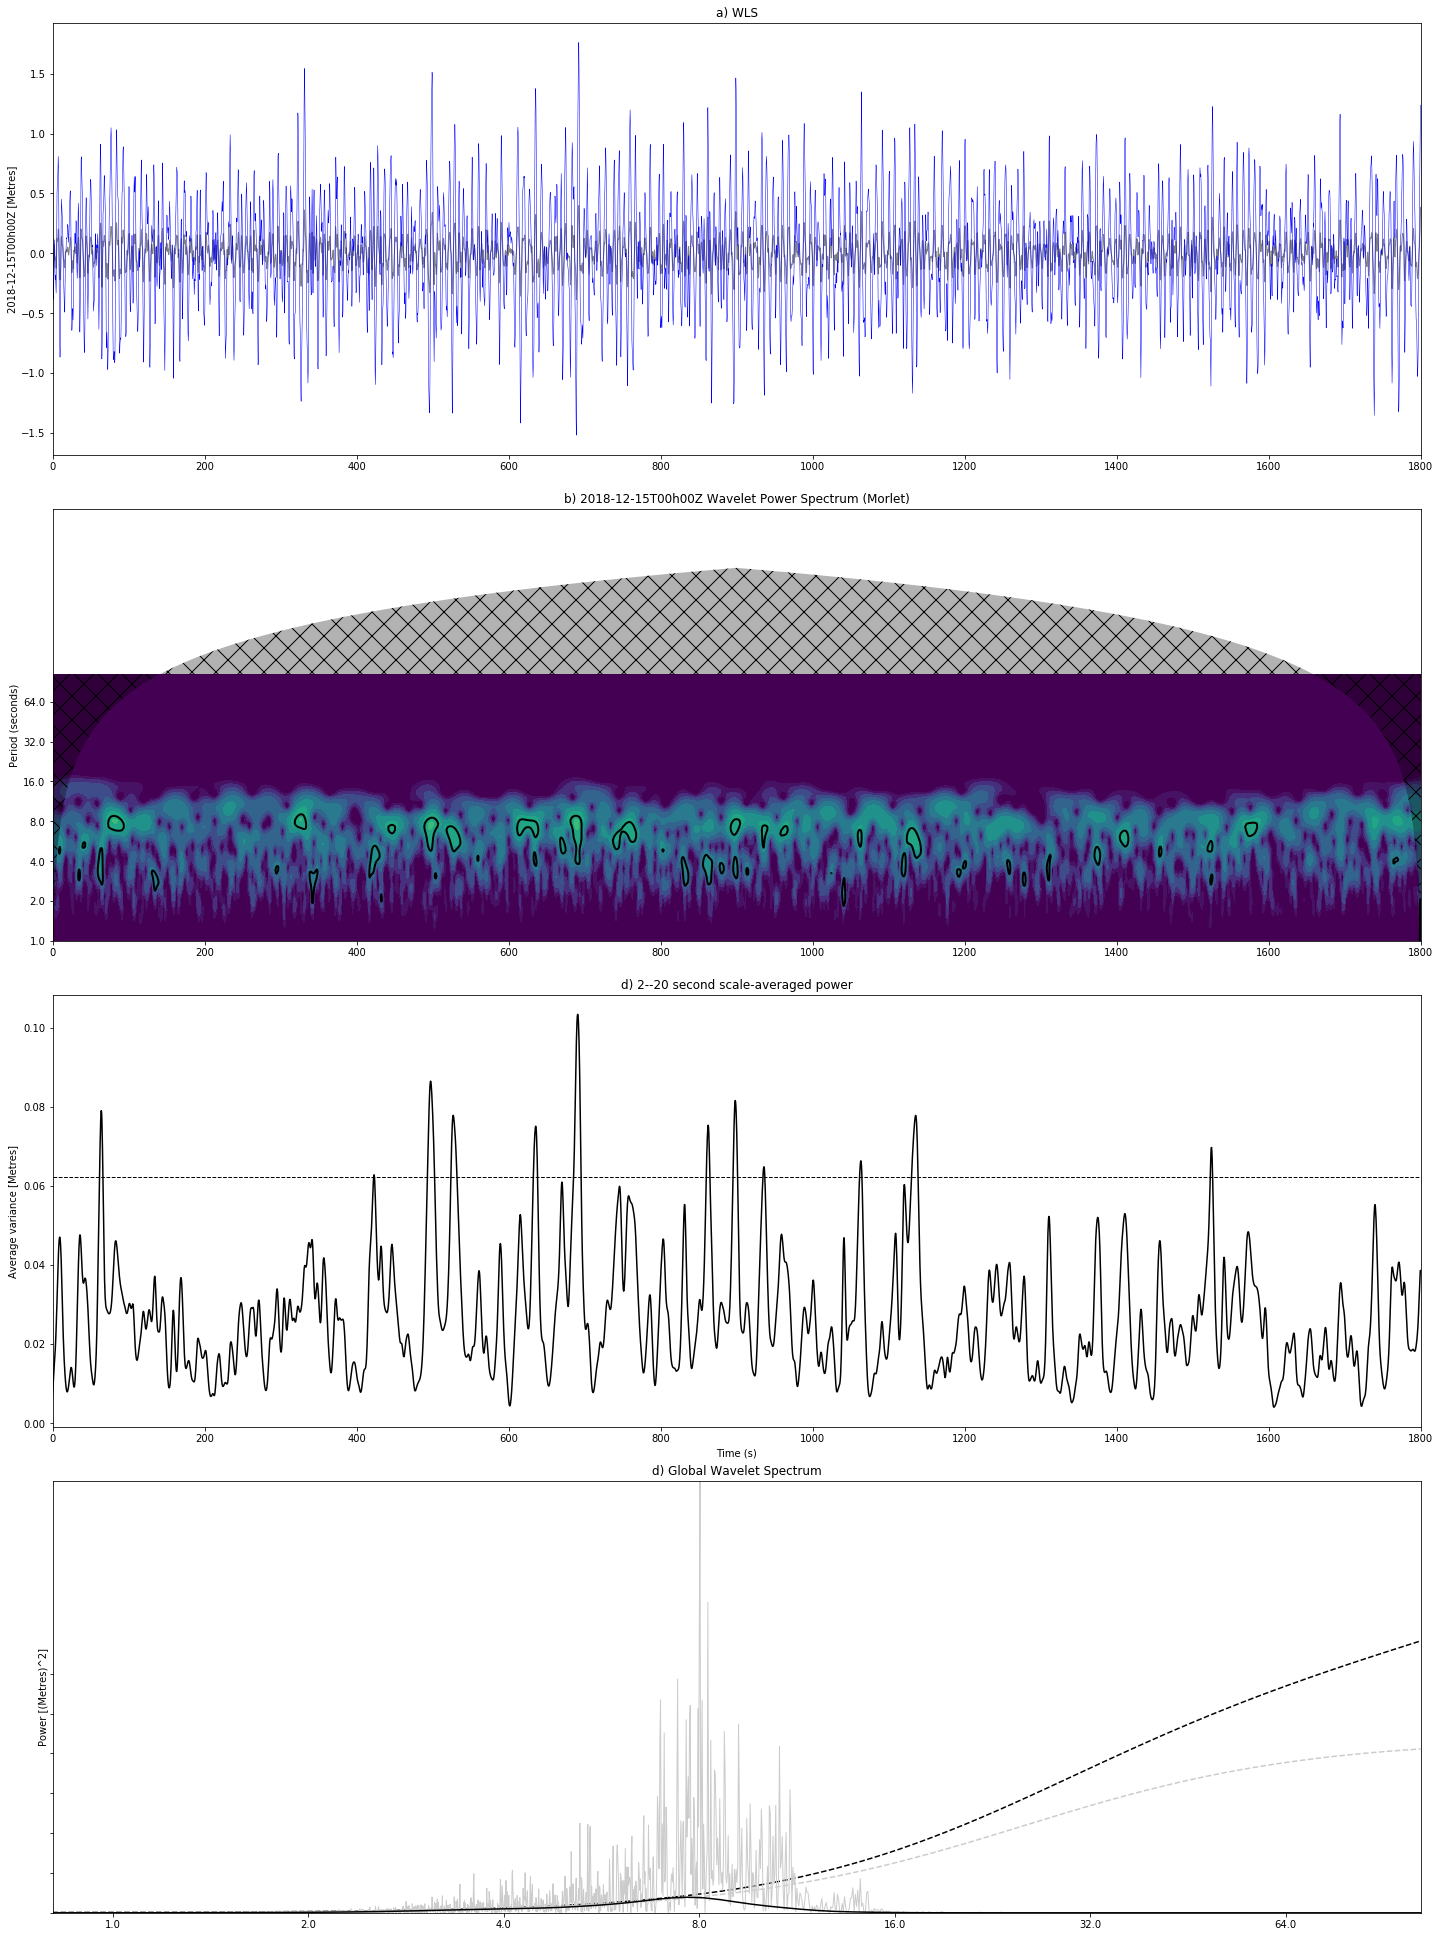

In [18]:
master = Tk()
colorama.init()
# Get name of input PRIM file
Input_HVA_File = get_file()

date_str = Input_HVA_File.split('}')[1].split('.')[0]
Start_time = datetime.strptime(date_str, "%Y-%m-%dT%Hh%MZ") + timedelta(hours=10)
Next_time = Start_time; F20_time = Start_time; F23_time = datetime.now()

# Open file
f = open(Input_HVA_File)

# Read data from the Binary file into a DF based on the structure in the DT
print('Reading data from ',f)
#data = pd.DataFrame(np.fromfile(f, BB1))

data = pd.read_csv(f, names=['Cycle_counter','Displacements_List','Packet_List'], header=None)

# Build the HVA format
Displacements_DF = data.Displacements_List

# Transform DF into List
Displacements_List = []; 
print('Building Displacement data array')
Displacements_List = Displacements_DF.tolist()
Position = [2403]
Sample_number = 4608.0
Status = []; wls = []; north = []; west = []
Get_Displacements(Position,Sample_number, Status, Displacements_List, wls, north, west)

dat = wls
title = 'WLS'
label = date_str
units = 'Metres'
t0 = 0
dt = 1/2.56  # In seconds

# create a time array in seconds
N = len(dat)
t = numpy.arange(0, N) * dt + t0

#  detrend and normalize the input data by its standard deviation
p = numpy.polyfit(t - t0, dat, 1)
dat_notrend = dat - numpy.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset

# select the mother wavelet, in this case the Morlet wavelet with ω0=6.
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 seconds
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

# multiply the inverse transform by the standard deviation
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J, mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

# calculate the normalized wavelet and Fourier power spectra, as well as the Fourier equivalent periods for each wavelet scale
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs

# rectify the power spectrum according to the suggestions proposed by Liu et al. (2007)[2]
power /= scales[:, None]

# Do power spectra significance test. The power is significant where the ratio power / sig95 > 1.
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha, significance_level=0.95, wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95

# calculate the global wavelet spectrum and determine its significance level
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha, significance_level=0.95, dof=dof, wavelet=mother)

# calculate the scale average between 2 seconds and 20 seconds, and its significance level
sel = find((period >= 2) & (period < 8))
Cdelta = mother.cdelta
scale_avg = (scales * numpy.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,significance_level=0.95,dof=[scales[sel[0]],scales[sel[-1]]],wavelet=mother)

# plot our results in four different subplots containing the 
#   (i) original series anomaly and the inverse wavelet transform; 
#   (ii) the wavelet power spectrum 
#   (iii) the global wavelet and Fourier spectra ; and 
#   (iv) the range averaged wavelet spectrum. 
# In all sub-plots the significance levels are either included as dotted lines or as filled contour lines

# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(20, 30), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet transform.
####################################################################
ax = pyplot.axes([0.1, 0.8, 0.95, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=0.5,color='b')
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
####################################################################
bx = pyplot.axes([0.1, 0.575, 0.95, 0.2], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (seconds)')
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the scale averaged wavelet spectrum.
####################################################################
cx = pyplot.axes([0.1, 0.35, 0.95, 0.2], sharex=ax)
cx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
cx.plot(t, scale_avg, 'k-', linewidth=1.5)
cx.set_title('d) {}--{} second scale-averaged power'.format(2, 20))
cx.set_xlabel('Time (s)')
cx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

# Fourth sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
####################################################################
dx = pyplot.axes([0.1, 0.125, 0.95, 0.2], sharey=bx)
dx.plot(numpy.log2(period),glbl_signif, 'k--')
dx.plot(numpy.log2(period),var * fft_theor, '--', color='#cccccc')
dx.plot(numpy.log2(1./fftfreqs),var * fft_power, '-', color='#cccccc',
        linewidth=1.)
dx.plot(numpy.log2(period),var * glbl_power,'k-', linewidth=1.5)
dx.set_title('d) Global Wavelet Spectrum')
dx.set_ylabel(r'Power [({})^2]'.format(units))
dx.set_ylim([0, max(var * fft_power)])
dx.set_xlim(numpy.log2([period.min(), period.max()]))
dx.set_xticks(numpy.log2(Yticks))
dx.set_xticklabels(Yticks)
pyplot.setp(dx.get_yticklabels(), visible=False)


pyplot.show()

In [15]:
max(period)

103.30436477492538